# Mise en correspondance d’images
## Calcul des points d'intêret


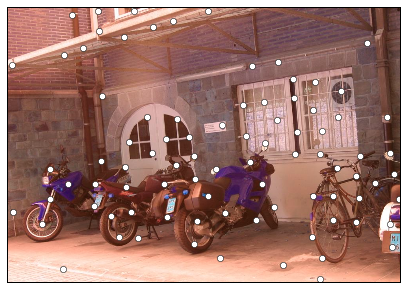

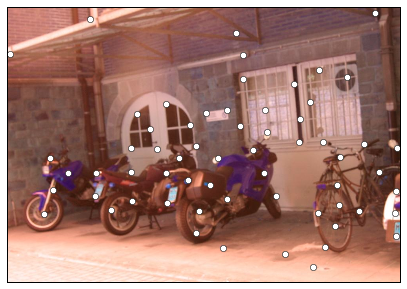

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
%matplotlib inline

def _plot(img, size=2.0):
    plt.subplots_adjust(left=0.0, right=size, bottom=0.0, top=size)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def plot_one(img, size=2.0):
    plt.figure()
    plt.subplot(121)
    _plot(img, size)
    
def plot_by_pair(img1, img2):
    plt.figure()
    plt.subplot(121)
    _plot(img1)
    plt.subplot(122)
    _plot(img2)



# goodFeaturesToTrack
def test_goodFeaturesToTrack(img_name):
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    points = cv2.goodFeaturesToTrack(gray, 100, 0.1, 50)
    points = [p[0] for p in points]
    
    plot_one(img)
    plt.plot(*zip(*points), marker='o', color='w', ls='')
    

test_goodFeaturesToTrack("bikes/img_7069.ppm")
test_goodFeaturesToTrack("bikes/img_7075.ppm")

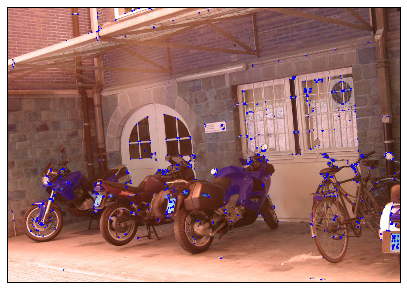

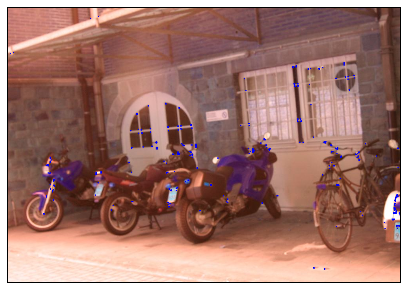

In [4]:
def test_cornerHarris(img_name):
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = cv2.cornerHarris(gray,2,3,0.04)

    # result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    # threshold for an optimal value, it may vary depending on the image.
    img[dst>0.02*dst.max()]=[0,0,255]
    
    plot_one(img)

test_cornerHarris("bikes/img_7069.ppm")
test_cornerHarris("bikes/img_7075.ppm")

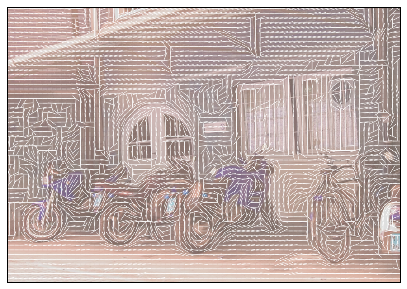

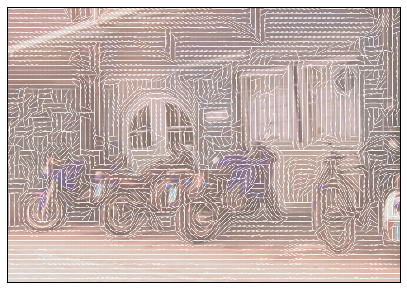

In [5]:
def test_cornerMinEigenVal(img_name):
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape[:2]
    eigen = cv2.cornerEigenValsAndVecs(gray, 30, 7)
    eigen = eigen.reshape(h, w, 3, 2)  # [[e1, e2], v1, v2]
    flow = eigen[:,:,2]

    vis = img.copy()
    vis[:] = (192 + np.uint32(vis)) / 2
    d = 12
    points =  np.dstack( np.mgrid[d/2:w:d, d/2:h:d] ).reshape(-1, 2)
    for x, y in points:
       vx, vy = np.int32(flow[y, x]*d)
       cv2.line(vis, (x-vx, y-vy), (x+vx, y+vy), (255, 255, 255), 1, cv2.CV_AA)

    plot_one(vis)

test_cornerMinEigenVal("bikes/img_7069.ppm")
test_cornerMinEigenVal("bikes/img_7075.ppm")

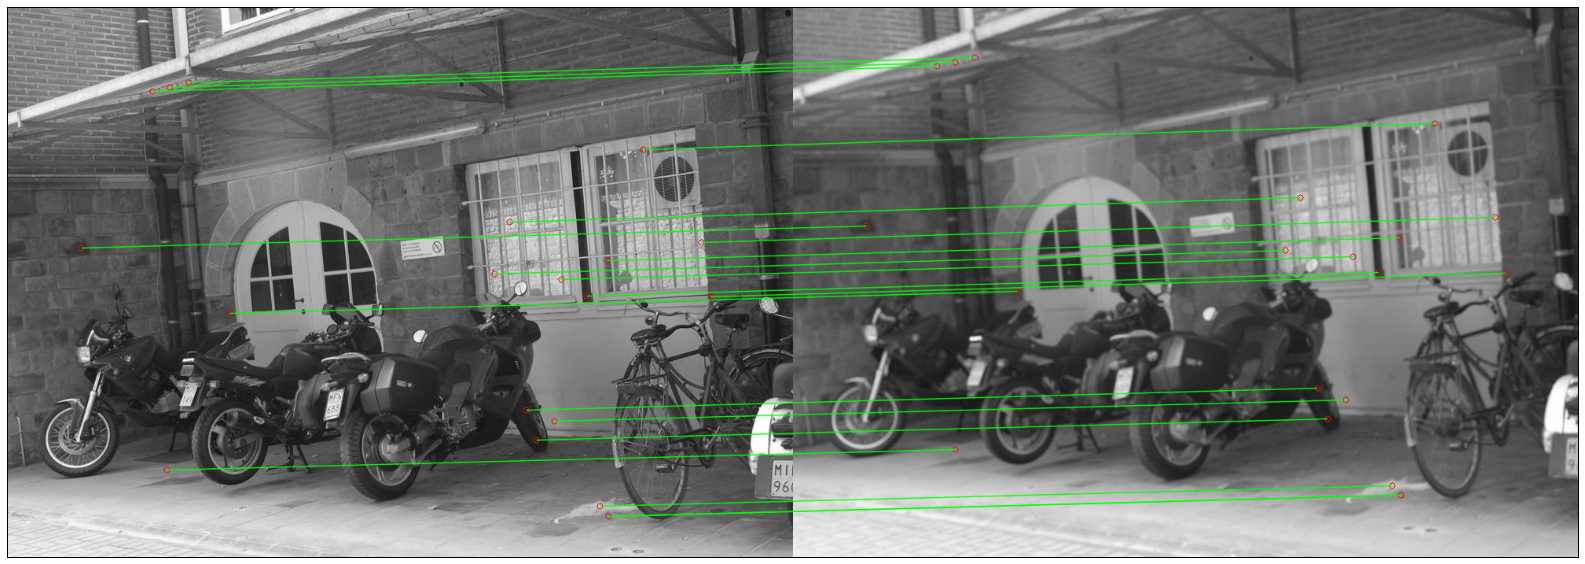

In [49]:
def draw_matches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1, rows2]), cols1 + cols2, 3), dtype='uint8')

    # Place the first image to the left
    out[:rows1, :cols1, :] = np.dstack([img1, img1, img1])
    
    # Place the next image to the right of it
    out[:rows2, cols1:cols1 + cols2, :] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        x1, y1 = kp1[img1_idx].pt
        x2, y2 = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1), int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2) + cols1, int(y2)), 4, (255, 0, 0), 1)
        
        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1), int(y1)), (int(x2) + cols1, int(y2)), (0, 255, 0), 1, cv2.CV_AA)
    
    plot_one(out, 8)

def test_sift(img1_name, img2_name):
    img1 = cv2.imread(img1_name)
    img2 = cv2.imread(img2_name)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    good = sorted(good, key=lambda x: x.distance)

    draw_matches(img1, kp1, img2, kp2, good[:20])

test_sift("bikes/img_7069.ppm", "bikes/img_7075.ppm")

## Calcul de la similarité entre les deux images